In [2]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import jax.numpy as jnp
import jax.random as jrng
import jax.scipy as jsp 
import numpy as np
import ultraplot as uplt

In [5]:
from constr_hmc import constr_hmc

In [6]:
from numpyro.diagnostics import print_summary

def _emcee_to_numpyro(chain, rng_key):
    inds = jrng.permutation(rng_key, chain.shape[0])
    _, rng_key = jrng.split(rng_key)

    samples = dict()
    for i in range(chain.shape[2]):
        samples[f"p{i}"] = chain[inds, :, i].T
    return samples, rng_key

def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return 0.5 * jnp.sum((x-mu)**2) / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi)

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2
    return _neg_log_like_gauss1d(x, 1)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         -_neg_log_like_gauss1d(x, 1),
    #         -_neg_log_like_gauss1d(x, 1, mu=3),
    #     ])
    # )


def _log_like(x):
    return -1.0 * _neg_log_like(x)


def _constraint(x):
    return jnp.exp(_log_like(x)) - jnp.exp(-1.0 * _neg_log_like_gauss1d(0.5, 1.0))

_log_like_arr = jax.vmap(_log_like)


In [ ]:
n_dims = 2
n_samples = 1000000

rng_key = jrng.PRNGKey(seed=10)
rng_key, init_key = jrng.split(rng_key)
x_init = jrng.normal(init_key, shape=(n_dims,)) * 0.01

n_steps = 3
h = 0.2
chain, acc, nloglike = constr_hmc(
    _neg_log_like,
    x_init,
    n_samples,
    n_dims,
    h,
    n_steps,
    _constraint,
    rng_key
)

samples, rng_key = _emcee_to_numpyro(chain[n_samples // 2:, :, :], rng_key)

print_summary(samples)

sampling: 100%|███████████████████| 1000000/1000000 [00:05<00:00, 180742.60it/s]


acceptance rate: 4.73%

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        p0      0.00      0.25      0.00     -0.37      0.42 498853.05      1.00
        p1      0.00      0.25      0.00     -0.40      0.40 496741.89      1.00



<a list of 1 Line2D objects>

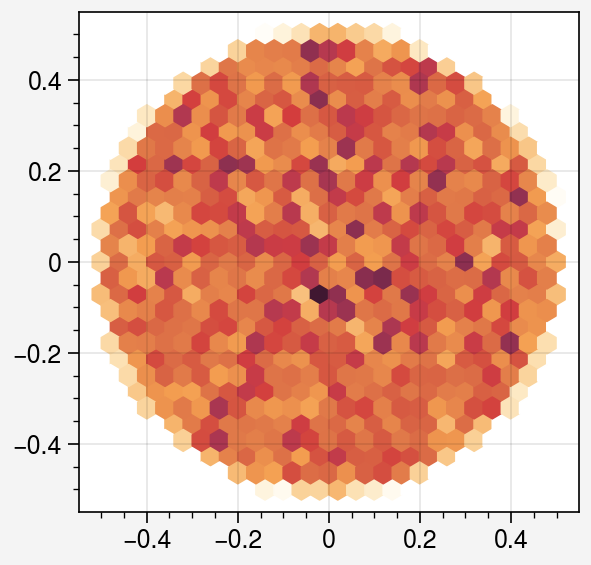

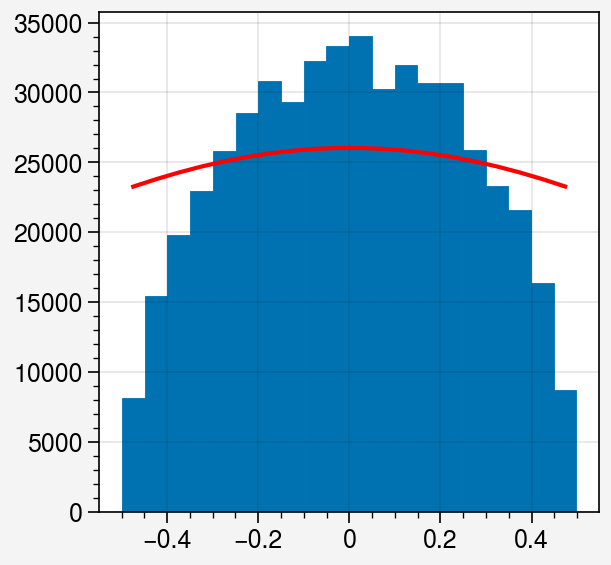

In [11]:
if n_dims >= 2:
    fig, axs = uplt.subplots()

    axs.hexbin(
        samples["p0"].ravel(),
        samples["p1"].ravel(),
        gridsize=25,
    );


fig, axs = uplt.subplots()

h, be, _ = axs.hist(
    samples["p0"].ravel(),
    bins=20,
);

n = samples["p0"].ravel().shape[0]
x = (be[1:] + be[:-1]) / 2.0
dx = be[1] - be[0]

vals = jnp.exp(_log_like_arr(x)) * dx
vals /= jnp.sum(vals)

axs.plot(x, vals * n, color="r")
